In [0]:
# Fetch German Traffic Sign Recognition Benchmark Dataset (Test)
!wget -nc https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
!wget -nc https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip

# Fetch Trained Kernel
!wget -nc https://codingvision.net/.dan/isc/0.9582710011507479-gtsrb-lenet5.dat

# *sigh*
!unzip GTSRB_Final_Test_Images.zip
!unzip GTSRB_Final_Test_GT.zip

Streaming output truncated to the last 5000 lines.
  inflating: GTSRB/Final_Test/Images/07635.ppm  
  inflating: GTSRB/Final_Test/Images/07636.ppm  
  inflating: GTSRB/Final_Test/Images/07637.ppm  
  inflating: GTSRB/Final_Test/Images/07638.ppm  
  inflating: GTSRB/Final_Test/Images/07639.ppm  
  inflating: GTSRB/Final_Test/Images/07640.ppm  
  inflating: GTSRB/Final_Test/Images/07641.ppm  
  inflating: GTSRB/Final_Test/Images/07642.ppm  
  inflating: GTSRB/Final_Test/Images/07643.ppm  
  inflating: GTSRB/Final_Test/Images/07644.ppm  
  inflating: GTSRB/Final_Test/Images/07645.ppm  
  inflating: GTSRB/Final_Test/Images/07646.ppm  
  inflating: GTSRB/Final_Test/Images/07647.ppm  
  inflating: GTSRB/Final_Test/Images/07648.ppm  
  inflating: GTSRB/Final_Test/Images/07649.ppm  
  inflating: GTSRB/Final_Test/Images/07650.ppm  
  inflating: GTSRB/Final_Test/Images/07651.ppm  
  inflating: GTSRB/Final_Test/Images/07652.ppm  
  inflating: GTSRB/Final_Test/Images/07653.ppm  
  inflating: GTSRB

In [0]:
from torch.utils.data import Dataset
from torchvision import transforms, datasets
from PIL import Image
import pandas as pd
import os
import torch

class TrafficSignDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        self.labels_frame = pd.read_csv(csv_file, sep=";")
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.labels_frame)
    
    def __getitem__(self, idx):
        img = self.labels_frame.iloc[idx]
        image = Image.open(os.path.join(self.root_dir, img['Filename']))
        label = img['ClassId']
        
        if self.transform:
            image = self.transform(image)
        
        sample = [image, label]
        
        return sample

test_dataset_root = 'GTSRB/Final_Test/Images/'

test_image_folder = TrafficSignDataset('GT-final_test.csv', test_dataset_root,
                           transform=transforms.Compose([
                               transforms.Resize(32),
                               transforms.CenterCrop(32),
                               transforms.Grayscale(),
                               transforms.ToTensor(),
                               
                           ]))

test_dataloader = torch.utils.data.DataLoader(test_image_folder, batch_size=32, shuffle=True, num_workers=1)

TRAFFIC_SIGNS_LABELS = {
    0: '20_speed',
    1: '30_speed',
    2: '50_speed',
    3: '60_speed',
    4: '70_speed',
    5: '80_speed',
    6: '80_lifted',
    7: '100_speed',
    8: '120_speed',
    9: 'no_overtaking_general',
    10: 'no_overtaking_trucks',
    11: 'right_of_way_crossing',
    12: 'right_of_way_general',
    13: 'give_way',
    14: 'stop',
    15: 'no_way_general',
    16: 'no_way_trucks',
    17: 'no_way_one_way',
    18: 'attention_general',
    19: 'attention_left_turn',
    20: 'attention_right_turn',
    21: 'attention_curvy',
    22: 'attention_bumpers',
    23: 'attention_slippery',
    24: 'attention_bottleneck',
    25: 'attention_construction',
    26: 'attention_traffic_light',
    27: 'attention_pedestrian',
    28: 'attention_children',
    29: 'attention_bikes',
    30: 'attention_snowflake',
    31: 'attention_deer',
    32: 'lifted_general',
    33: 'turn_right',
    34: 'turn_left',
    35: 'turn_straight',
    36: 'turn_straight_right',
    37: 'turn_straight_left',
    38: 'turn_right_down',
    39: 'turn_left_down',
    40: 'turn_circle',
    41: 'lifted_no_overtaking_general',
    42: 'lifted_no_overtaking_trucks'
}

INV_TRAFFIC_SIGNS_LABELS = {l:c for c,l in TRAFFIC_SIGNS_LABELS.items()}


In [0]:
import torch.nn as nn
import torch.nn.functional as F


# disclaimer: bn1 and bn2 should've been renamed to in1 and in2 as they perform Instance Normalization (and not Batch Normalization)
# renaming them would render the state_dict incomaptible with the new network. I'm too lazy to retrain the network :/

class LeNet(nn.Module):
  def __init__(self, num_classes=47, affine=True):
      super().__init__()
      self.conv1 = nn.Conv2d(1, 32, 5)
      self.bn1 = nn.InstanceNorm2d(32, affine=affine)
      self.conv2 = nn.Conv2d(32, 64, 5)
      self.bn2 = nn.InstanceNorm2d(64, affine=affine)
      self.fc1 = nn.Linear(64 * 5 * 5, 256)
      self.fc2 = nn.Linear(256, 128)
      self.fc3 = nn.Linear(128, num_classes)


  def forward(self, x):
      out = F.relu(self.bn1(self.conv1(x)))
      out = F.max_pool2d(out, 2)
      out = F.relu(self.bn2(self.conv2(out)))
      out = F.max_pool2d(out, 2)
      out = out.view(out.size(0), -1)
      out = F.relu(self.fc1(out))
      out = F.relu(self.fc2(out))
      out = self.fc3(out)
      return out

use_gpu = torch.cuda.is_available()

net = LeNet(num_classes = 43)
if not use_gpu:
  net.load_state_dict(torch.load('0.9582710011507479-gtsrb-lenet5.dat', map_location=torch.device('cpu')))
else:
  net.load_state_dict(torch.load('0.9582710011507479-gtsrb-lenet5.dat'))
  net = net.cuda()

In [0]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy = 0
precision = 0
recall = 0

num_batches = 0

for X, y_true in test_dataloader:
  if use_gpu:
    X = X.cuda()
    y_true = y_true.cuda()

  y_pred = net(X)

  if use_gpu:
    y_pred = y_pred.cpu()
    y_true = y_true.cpu()

  y_pred = y_pred.detach().numpy()
  y_true = y_true.detach().numpy()
  
  y_pred = np.argmax(y_pred, axis=1)

  accuracy += accuracy_score(y_true, y_pred)
  precision += precision_score(y_true, y_pred, average='macro')
  recall += recall_score(y_true, y_pred, average='macro')
  num_batches +=1

accuracy /= num_batches
precision /= num_batches
recall /= num_batches

print('-- Stats --')
print('ACC:', accuracy, 'PRE:', precision, 'REC:', recall)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


-- Stats --
ACC: 0.9582710011507479 PRE: 0.9294650362214106 REC: 0.927870099924181


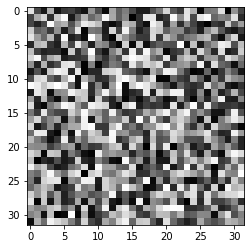

Predicted: turn_left_down
Loss: tensor(58.5501, device='cuda:0', grad_fn=<AddBackward0>)


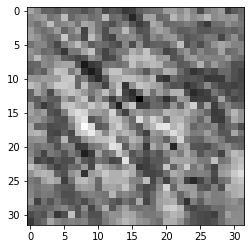

Predicted: stop
Loss: tensor(2.2363, device='cuda:0', grad_fn=<AddBackward0>)


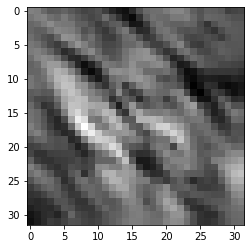

Predicted: stop
Loss: tensor(0.1076, device='cuda:0', grad_fn=<AddBackward0>)


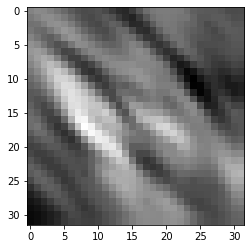

Predicted: stop
Loss: tensor(0.0162, device='cuda:0', grad_fn=<AddBackward0>)


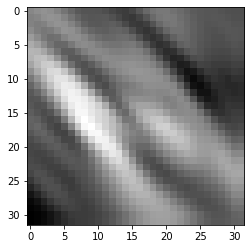

Predicted: stop
Loss: tensor(0.0051, device='cuda:0', grad_fn=<AddBackward0>)


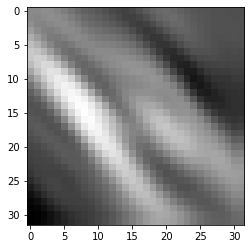

Predicted: stop
Loss: tensor(0.0024, device='cuda:0', grad_fn=<AddBackward0>)


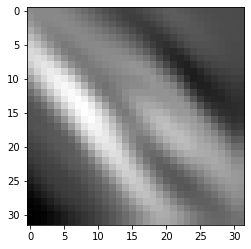

Predicted: stop
Loss: tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)


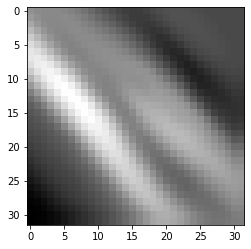

Predicted: stop
Loss: tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)


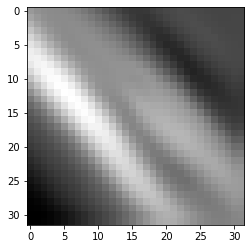

Predicted: stop
Loss: tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)


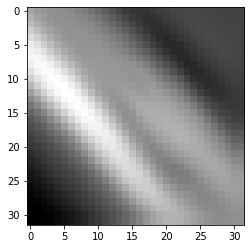

Predicted: stop
Loss: tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)


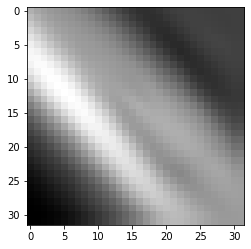

Predicted: stop
Loss: tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


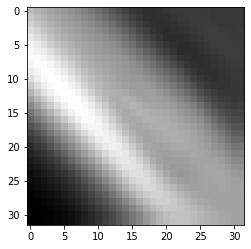

Predicted: stop
Loss: tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


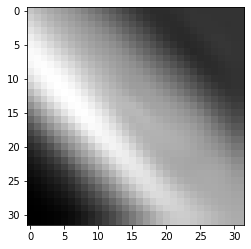

Predicted: stop
Loss: tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)


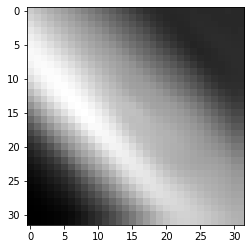

Predicted: stop
Loss: tensor(9.9074e-05, device='cuda:0', grad_fn=<AddBackward0>)


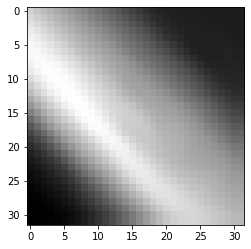

Predicted: stop
Loss: tensor(7.5784e-05, device='cuda:0', grad_fn=<AddBackward0>)


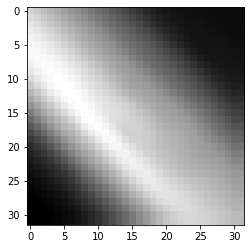

Predicted: stop
Loss: tensor(5.7778e-05, device='cuda:0', grad_fn=<AddBackward0>)


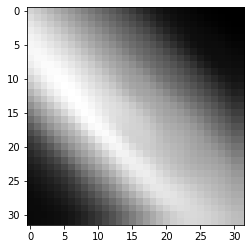

Predicted: stop
Loss: tensor(4.2137e-05, device='cuda:0', grad_fn=<AddBackward0>)


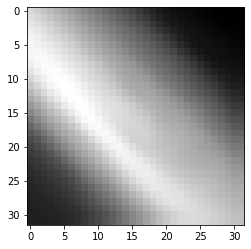

Predicted: stop
Loss: tensor(3.0339e-05, device='cuda:0', grad_fn=<AddBackward0>)


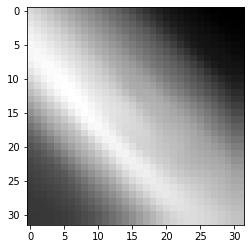

Predicted: stop
Loss: tensor(1.8823e-05, device='cuda:0', grad_fn=<AddBackward0>)


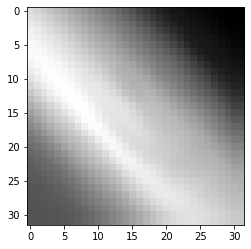

Predicted: stop
Loss: tensor(1.1837e-05, device='cuda:0', grad_fn=<AddBackward0>)


In [0]:
import matplotlib.pyplot as plt


targeted_adversarial_class = torch.tensor([INV_TRAFFIC_SIGNS_LABELS['stop']])

adversarial_sample = torch.rand((1, 1, 32, 32))

kernel = torch.FloatTensor([[[0, 0, 0], [0, -3, 1], [0, 1, 1]]]).view(1,1,3,3)

if use_gpu:
  adversarial_sample = adversarial_sample.cuda()
  targeted_adversarial_class = targeted_adversarial_class.cuda()
  kernel = kernel.cuda()

adversarial_sample.requires_grad_() 

adversarial_optimizer = torch.optim.Adam([adversarial_sample], lr=1e-3)





for i in range(10000):

  adversarial_optimizer.zero_grad()
  
  prediction = net(adversarial_sample)
  
  loss = torch.nn.CrossEntropyLoss()(prediction, targeted_adversarial_class) + \
          0.05*((torch.nn.functional.conv2d(torch.nn.functional.pad(adversarial_sample, (1,1,1,1), 'reflect'), kernel)**2).sum())
  
  if use_gpu:
    prediction = prediction.cpu()

  predicted_class = np.argmax(prediction.detach().numpy(), axis=1)

  loss.backward()
  adversarial_optimizer.step()

  adversarial_sample.data = torch.clamp(adversarial_sample.data, 0, 1)
  

  if i % 500 == 0:

    if use_gpu:
      plt.imshow(adversarial_sample.data.cpu().view(32, 32), cmap='gray')
    else:
      plt.imshow(adversarial_sample.data.view(32, 32), cmap='gray')
    plt.show()
    print('Predicted:', TRAFFIC_SIGNS_LABELS[predicted_class[0]])
    print('Loss:', loss)
    



